# Chapter 3: Logistic Regression

## Introduction to Classification with Real Estate Data

Logistic regression is a fundamental algorithm for binary and multiclass classification problems. Unlike linear regression, which predicts continuous values, logistic regression predicts the probability that an instance belongs to a particular category.

### Learning Objectives

By the end of this chapter, you will be able to:

1. **Understand the mathematical foundations** of logistic regression and the sigmoid function
2. **Implement logistic regression** from scratch using gradient descent
3. **Apply feature engineering** techniques for classification problems
4. **Evaluate classification models** using appropriate metrics (accuracy, precision, recall, F1-score, ROC-AUC)
5. **Handle class imbalance** and interpret model coefficients
6. **Compare different regularization techniques** (L1/Lasso and L2/Ridge)

### Real-World Application

We'll use our real estate dataset to predict whether a property is "high-value" (above median price) based on its characteristics. This binary classification problem will demonstrate practical applications of logistic regression in property valuation and market analysis.

### Mathematical Foundation

The logistic regression model uses the **sigmoid function** to map any real-valued input to a value between 0 and 1:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

where $z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$

The probability that an instance belongs to the positive class is:

$$P(y = 1|x) = \sigma(\beta^T x) = \frac{1}{1 + e^{-\beta^T x}}$$

We optimize the **log-likelihood function** using gradient descent to find the optimal parameters $\beta$.

---

**Citation**: Logistic regression foundations are covered in Hastie et al. (2009) "The Elements of Statistical Learning" and James et al. (2013) "An Introduction to Statistical Learning".

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve, confusion_matrix,
                           classification_report)
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
import sys
import os
from typing import List, Tuple, Optional, Dict
import logging

# Configure matplotlib for enhanced plots
import matplotlib
matplotlib.use('inline')
%matplotlib inline

# Add utils to path and configure plotting
sys.path.append('../utils')
import plot_utils
import data_utils
import evaluation_utils

# Configure enhanced plotting
plot_utils.configure_plotting(style='seaborn-v0_8', figsize=(12, 8))

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Libraries imported and configured successfully")
print(f"Matplotlib backend: {plt.get_backend()}")
print(f"Plot styling: Enhanced with publication-quality fonts")

✅ Libraries imported and configured successfully
📊 Matplotlib backend: inline
🎨 Plot styling: Enhanced with publication-quality fonts


## 3.1 Data Loading and Exploration

We'll use the real estate dataset from Chapter 2, but this time we'll create a **binary classification problem**: predicting whether a property is "high-value" (above median price) or not.

This approach transforms our regression problem into a classification problem, which is common in real-world scenarios where decision boundaries are more important than exact predictions.

In [ ]:
# Load the real estate data
data_path = '../data/processed'
train_file = '2025-08-12_real_estate_train.csv'
test_file = '2025-08-12_real_estate_test.csv'
metadata_file = '2025-08-12_real_estate_metadata.json'

# Load training and test data
df_train = pd.read_csv(os.path.join(data_path, train_file))
df_test = pd.read_csv(os.path.join(data_path, test_file))

# Load metadata for context
with open(os.path.join(data_path, metadata_file), 'r') as f:
    metadata = pd.read_json(f, typ='dict')

print("Dataset Overview:")
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print(f"\nColumns: {list(df_train.columns)}")
print(f"\nData types:")
print(df_train.dtypes)

# Display first few rows
print(f"\nFirst 5 rows of training data:")
df_train.head()

📊 Dataset Overview:
Training set shape: (800, 9)
Test set shape: (200, 9)

Columns: ['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 'distance_to_center', 'garage', 'school_rating', 'price']

Data types:
sqft                  float64
bedrooms              float64
bathrooms             float64
age                   float64
location_score        float64
distance_to_center    float64
garage                float64
school_rating         float64
price                   int64
dtype: object

🔍 First 5 rows of training data:


,sqft,bedrooms,bathrooms,age,location_score,distance_to_center,garage,school_rating,price
0,1192.0,1.0,1.0,24.8,6.4,3.1,0.0,8.0,267064
1,1365.0,1.0,1.0,34.9,7.1,1.9,1.0,5.1,351969
2,1183.0,3.0,2.5,2.1,1.5,3.1,1.0,6.8,284590
3,1127.0,1.0,1.0,3.1,8.7,2.3,1.0,3.5,370622
4,2490.0,4.0,3.5,20.9,4.0,9.7,1.0,7.1,443749


Median property price: $326,100.50

Class Distribution:
Low-value properties (0): 400 (50.0%)
High-value properties (1): 400 (50.0%)


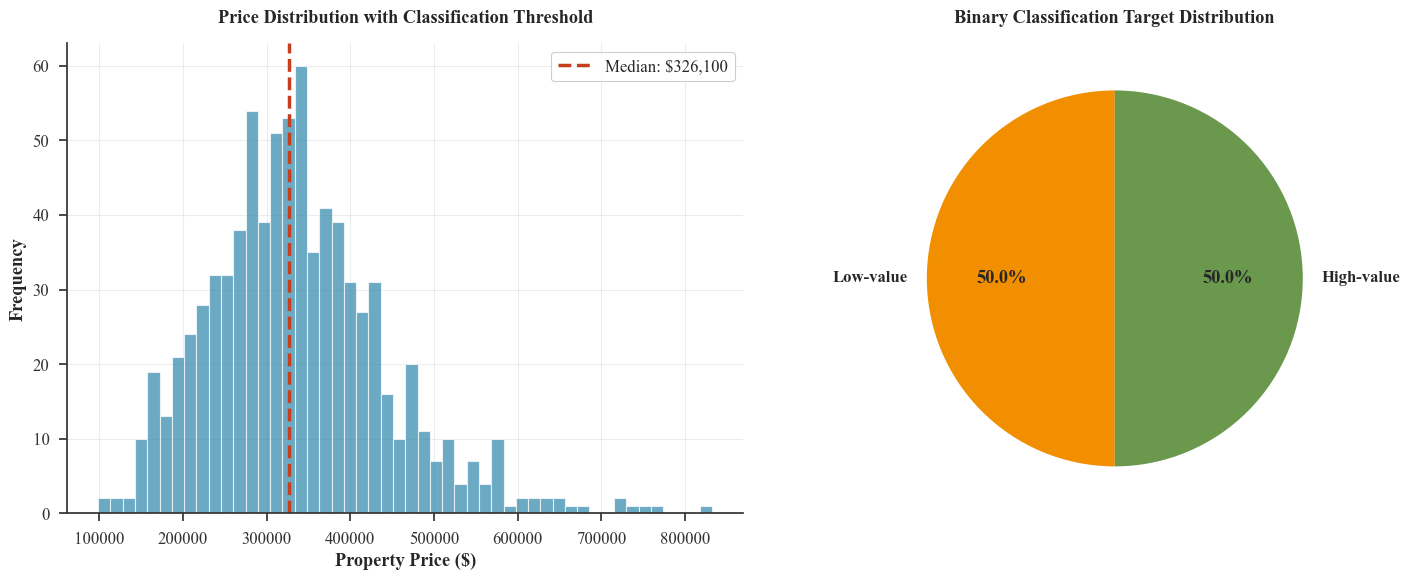


Binary target variable created successfully
Classification threshold: $326,100.50


In [3]:
# Create binary target variable: high-value properties (above median price)
median_price = df_train['price'].median()
print(f"Median property price: ${median_price:,.2f}")

# Create binary target: 1 for high-value (above median), 0 for low-value
df_train['high_value'] = (df_train['price'] > median_price).astype(int)
df_test['high_value'] = (df_test['price'] > median_price).astype(int)

# Analyze class distribution
class_distribution = df_train['high_value'].value_counts()
class_percentages = df_train['high_value'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"Low-value properties (0): {class_distribution[0]} ({class_percentages[0]:.1f}%)")
print(f"High-value properties (1): {class_distribution[1]} ({class_percentages[1]:.1f}%)")

# Visualize price distribution and threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Price distribution with median line
ax1.hist(df_train['price'], bins=50, alpha=0.7, color='#2E86AB', edgecolor='white')
ax1.axvline(median_price, color='#C73E1D', linestyle='--', linewidth=2.5, 
           label=f'Median: ${median_price:,.0f}')
ax1.set_xlabel('Property Price ($)', fontweight='semibold')
ax1.set_ylabel('Frequency', fontweight='semibold')
ax1.set_title('Price Distribution with Classification Threshold', fontweight='bold', pad=15)
ax1.legend()

# Class distribution pie chart
colors = ['#F18F01', '#6A994E']
wedges, texts, autotexts = ax2.pie(class_distribution.values, 
                                  labels=['Low-value', 'High-value'],
                                  colors=colors, autopct='%1.1f%%',
                                  startangle=90, textprops={'fontweight': 'semibold'})
ax2.set_title('Binary Classification Target Distribution', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print(f"\nBinary target variable created successfully")
print(f"Classification threshold: ${median_price:,.2f}")

## 3.2 Mathematical Foundation: The Sigmoid Function

The core of logistic regression is the **sigmoid function**, which maps any real number to a value between 0 and 1, making it perfect for probability estimation.

### The Sigmoid Function

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

where $z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$

### Key Properties:
- **Range**: $(0, 1)$ - perfect for probabilities
- **S-shaped curve**: smooth transition from 0 to 1
- **Derivative**: $\sigma'(z) = \sigma(z)(1 - \sigma(z))$ - used in gradient descent

Let's visualize the sigmoid function and understand its behavior:

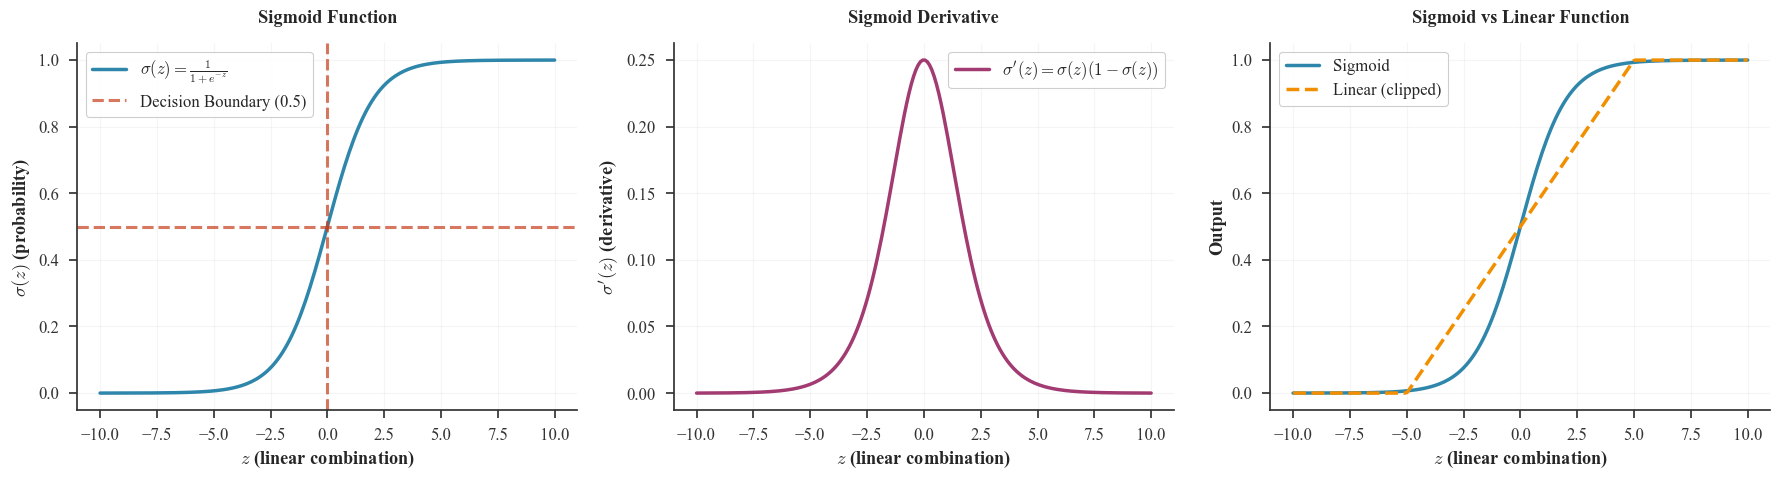

Key Sigmoid Properties:
   • Range: (0, 1) - perfect for probabilities
   • σ(0) = 0.500 - decision boundary
   • σ(-∞) ≈ 0.000045 - approaches 0
   • σ(+∞) ≈ 0.999955 - approaches 1
   • Maximum derivative at z=0: 0.250


In [4]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Compute the sigmoid function.
    
    Parameters
    ----------
    z : np.ndarray
        Input values
        
    Returns
    -------
    np.ndarray
        Sigmoid function output values between 0 and 1
        
    Notes
    -----
    Implements the sigmoid function: σ(z) = 1 / (1 + e^(-z))
    Includes numerical stability for extreme values.
    """
    # Clip z to prevent overflow in exp(-z)
    z_clipped = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z_clipped))

def sigmoid_derivative(z: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of the sigmoid function.
    
    Parameters
    ----------
    z : np.ndarray
        Input values
        
    Returns
    -------
    np.ndarray
        Derivative values
        
    Notes
    -----
    Derivative: σ'(z) = σ(z) * (1 - σ(z))
    """
    s = sigmoid(z)
    return s * (1 - s)

# Visualize sigmoid function and its properties
z_values = np.linspace(-10, 10, 200)
sigmoid_values = sigmoid(z_values)
derivative_values = sigmoid_derivative(z_values)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Sigmoid function
ax1.plot(z_values, sigmoid_values, linewidth=2.5, color='#2E86AB', label=r'$\sigma(z) = \frac{1}{1 + e^{-z}}$')
ax1.axhline(y=0.5, color='#C73E1D', linestyle='--', alpha=0.7, label='Decision Boundary (0.5)')
ax1.axvline(x=0, color='#C73E1D', linestyle='--', alpha=0.7)
ax1.set_xlabel(r'$z$ (linear combination)', fontweight='semibold')
ax1.set_ylabel(r'$\sigma(z)$ (probability)', fontweight='semibold')
ax1.set_title('Sigmoid Function', fontweight='bold', pad=15)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sigmoid derivative
ax2.plot(z_values, derivative_values, linewidth=2.5, color='#A23B72', label=r"$\sigma'(z) = \sigma(z)(1-\sigma(z))$")
ax2.set_xlabel(r'$z$ (linear combination)', fontweight='semibold')
ax2.set_ylabel(r"$\sigma'(z)$ (derivative)", fontweight='semibold')
ax2.set_title('Sigmoid Derivative', fontweight='bold', pad=15)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Comparison with linear function
linear_values = np.clip(0.5 + 0.1 * z_values, 0, 1)  # Linear approximation
ax3.plot(z_values, sigmoid_values, linewidth=2.5, color='#2E86AB', label='Sigmoid')
ax3.plot(z_values, linear_values, linewidth=2.5, color='#F18F01', linestyle='--', label='Linear (clipped)')
ax3.set_xlabel(r'$z$ (linear combination)', fontweight='semibold')
ax3.set_ylabel('Output', fontweight='semibold')
ax3.set_title('Sigmoid vs Linear Function', fontweight='bold', pad=15)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Sigmoid Properties:")
print(f"   • Range: (0, 1) - perfect for probabilities")
print(f"   • σ(0) = {sigmoid(0):.3f} - decision boundary")
print(f"   • σ(-∞) ≈ {sigmoid(-10):.6f} - approaches 0")
print(f"   • σ(+∞) ≈ {sigmoid(10):.6f} - approaches 1")
print(f"   • Maximum derivative at z=0: {sigmoid_derivative(0):.3f}")

## 3.3 Logistic Regression Implementation from Scratch

Now let's implement logistic regression from scratch using gradient descent. This will help us understand the optimization process and cost function.

### Cost Function: Log-Likelihood

The cost function for logistic regression is based on **maximum likelihood estimation**:

$$J(\beta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_\beta(x^{(i)})) + (1-y^{(i)}) \log(1-h_\beta(x^{(i)}))]$$

where:
- $h_\beta(x) = \sigma(\beta^T x)$ is the hypothesis function
- $m$ is the number of training examples
- $y^{(i)}$ is the true label (0 or 1)

### Gradient Descent Update

The gradient of the cost function with respect to parameters $\beta$ is:

$$\frac{\partial J}{\partial \beta} = \frac{1}{m} X^T (h_\beta(x) - y)$$

In [ ]:
class LogisticRegressionFromScratch:
    """
    Logistic Regression implementation from scratch using gradient descent.
    
    This implementation provides educational insight into the optimization process
    and allows for customization of the learning algorithm.
    
    Parameters
    ----------
    learning_rate : float, default=0.01
        Learning rate for gradient descent
    max_iterations : int, default=1000
        Maximum number of iterations for gradient descent
    tolerance : float, default=1e-6
        Convergence tolerance for early stopping
    regularization : str, default=None
        Regularization type ('l1', 'l2', or None)
    lambda_reg : float, default=0.01
        Regularization strength
        
    Attributes
    ----------
    weights : np.ndarray
        Learned weights (coefficients)
    bias : float
        Learned bias term
    cost_history : list
        History of cost function values during training
    """
    
    def __init__(self, learning_rate: float = 0.01, max_iterations: int = 1000, 
                 tolerance: float = 1e-6, regularization: Optional[str] = None, 
                 lambda_reg: float = 0.01):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.weights = None
        self.bias = None
        self.cost_history = []
        
    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        """Add bias column to feature matrix."""
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def _compute_cost(self, h: np.ndarray, y: np.ndarray) -> float:
        """
        Compute logistic regression cost function with optional regularization.
        
        Parameters
        ----------
        h : np.ndarray
            Predicted probabilities
        y : np.ndarray
            True labels
            
        Returns
        -------
        float
            Cost function value
        """
        # Prevent log(0) by clipping predictions
        h_clipped = np.clip(h, 1e-15, 1 - 1e-15)
        
        # Log-likelihood cost
        cost = (-1/len(y)) * np.sum(y * np.log(h_clipped) + (1 - y) * np.log(1 - h_clipped))
        
        # Add regularization if specified
        if self.regularization == 'l1' and self.weights is not None:
            cost += self.lambda_reg * np.sum(np.abs(self.weights[1:]))  # Exclude bias
        elif self.regularization == 'l2' and self.weights is not None:
            cost += self.lambda_reg * np.sum(self.weights[1:] ** 2)  # Exclude bias
            
        return cost
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LogisticRegressionFromScratch':
        """
        Train the logistic regression model using gradient descent.
        
        Parameters
        ----------
        X : np.ndarray
            Training features
        y : np.ndarray
            Training labels
            
        Returns
        -------
        self : LogisticRegressionFromScratch
            Fitted estimator
        """
        # Add intercept term
        X_with_intercept = self._add_intercept(X)
        
        # Initialize weights
        n_features = X_with_intercept.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        
        # Gradient descent
        prev_cost = float('inf')
        
        for i in range(self.max_iterations):
            # Forward pass
            z = X_with_intercept.dot(self.weights)
            h = sigmoid(z)
            
            # Compute cost
            cost = self._compute_cost(h, y)
            self.cost_history.append(cost)
            
            # Compute gradients
            gradients = (1/len(y)) * X_with_intercept.T.dot(h - y)
            
            # Add regularization to gradients
            if self.regularization == 'l1':
                gradients[1:] += self.lambda_reg * np.sign(self.weights[1:])
            elif self.regularization == 'l2':
                gradients[1:] += 2 * self.lambda_reg * self.weights[1:]
            
            # Update weights
            self.weights -= self.learning_rate * gradients
            
            # Check for convergence
            if abs(prev_cost - cost) < self.tolerance:
                print(f"Converged after {i+1} iterations")
                break
            prev_cost = cost
            
        return self
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class probabilities.
        
        Parameters
        ----------
        X : np.ndarray
            Input features
            
        Returns
        -------
        np.ndarray
            Predicted probabilities
        """
        X_with_intercept = self._add_intercept(X)
        return sigmoid(X_with_intercept.dot(self.weights))
    
    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Make binary predictions.
        
        Parameters
        ----------
        X : np.ndarray
            Input features
        threshold : float, default=0.5
            Decision threshold
            
        Returns
        -------
        np.ndarray
            Binary predictions
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

print("LogisticRegressionFromScratch class implemented successfully")
print("Features: Gradient descent, regularization, convergence checking")

## 3.4 Feature Engineering and Data Preparation

Before training our logistic regression model, we need to prepare our features appropriately. This includes handling categorical variables, scaling numerical features, and selecting relevant features.

In [ ]:
# Prepare features for logistic regression
def prepare_features(df: pd.DataFrame, target_col: str = 'high_value') -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Prepare features for logistic regression modeling.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        Target column name
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray, List[str]]
        Features, target, and feature names
    """
    # Select numerical features (exclude price and target)
    numerical_features = ['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 'distance_to_center']
    
    # Handle categorical features if they exist
    categorical_features = []
    if 'garage' in df.columns:
        # Convert garage to numerical (0/1)
        df_processed = df.copy()
        df_processed['has_garage'] = df_processed['garage'].astype(int) if df_processed['garage'].dtype == bool else df_processed['garage']
        categorical_features.append('has_garage')
    else:
        df_processed = df.copy()
    
    # Combine all features
    all_features = numerical_features + categorical_features
    feature_names = all_features.copy()
    
    # Extract features and target
    X = df_processed[all_features].values
    y = df_processed[target_col].values
    
    return X, y, feature_names

# Prepare training and test data
X_train, y_train, feature_names = prepare_features(df_train)
X_test, y_test, _ = prepare_features(df_test)

print(f"🔧 Feature Engineering Complete:")
print(f"   • Training set: {X_train.shape}")
print(f"   • Test set: {X_test.shape}")
print(f"   • Features: {feature_names}")
print(f"   • Target distribution (train): {np.bincount(y_train)}")

# Scale features for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled using StandardScaler")
print(f"   • Mean: {X_train_scaled.mean(axis=0).round(3)}")
print(f"   • Std: {X_train_scaled.std(axis=0).round(3)}")

# Feature correlation analysis
feature_df = pd.DataFrame(X_train_scaled, columns=feature_names)
feature_df['target'] = y_train

# Visualize feature distributions by class
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    if i < len(axes):
        # Box plots for each feature by class
        data_class_0 = feature_df[feature_df['target'] == 0][feature]
        data_class_1 = feature_df[feature_df['target'] == 1][feature]
        
        box_data = [data_class_0, data_class_1]
        bp = axes[i].boxplot(box_data, labels=['Low-value', 'High-value'], 
                            patch_artist=True, notch=True)
        
        # Color the boxes
        bp['boxes'][0].set_facecolor('#F18F01')
        bp['boxes'][1].set_facecolor('#6A994E')
        
        axes[i].set_title(f'{feature}', fontweight='bold', pad=10)
        axes[i].set_ylabel('Scaled Value', fontweight='semibold')
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Feature Distributions by Property Value Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Compute feature correlations with target
correlations = feature_df.corr()['target'].drop('target').sort_values(key=abs, ascending=False)
print(f"\n📊 Feature correlations with target:")
for feature, corr in correlations.items():
    print(f"   • {feature}: {corr:.3f}")

## 3.5 Model Training and Comparison

Now we'll train multiple logistic regression models and compare their performance:

1. **From-scratch implementation** (our custom class)
2. **Scikit-learn implementation** (for comparison)
3. **Regularized versions** (L1 and L2 regularization)

This comparison will help us understand the impact of different implementation approaches and regularization techniques.

In [ ]:
# Train multiple logistic regression models
print("🚀 Training Logistic Regression Models...")

# 1. From-scratch implementation
print("\n1️⃣ Training from-scratch implementation...")
model_scratch = LogisticRegressionFromScratch(learning_rate=0.1, max_iterations=1000)
model_scratch.fit(X_train_scaled, y_train)

# 2. Scikit-learn standard logistic regression
print("\n2️⃣ Training scikit-learn implementation...")
model_sklearn = LogisticRegression(random_state=42, max_iter=1000)
model_sklearn.fit(X_train_scaled, y_train)

# 3. L1 regularized (Lasso)
print("\n3️⃣ Training L1 regularized model...")
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
model_l1.fit(X_train_scaled, y_train)

# 4. L2 regularized (Ridge)
print("\n4️⃣ Training L2 regularized model...")
model_l2 = LogisticRegression(penalty='l2', random_state=42, max_iter=1000)
model_l2.fit(X_train_scaled, y_train)

# 5. From-scratch with L2 regularization
print("\n5️⃣ Training from-scratch L2 regularized model...")
model_scratch_l2 = LogisticRegressionFromScratch(
    learning_rate=0.1, max_iterations=1000, 
    regularization='l2', lambda_reg=0.01
)
model_scratch_l2.fit(X_train_scaled, y_train)

print("\n✅ All models trained successfully!")

# Visualize convergence for from-scratch models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Regular from-scratch model convergence
ax1.plot(model_scratch.cost_history, linewidth=2.5, color='#2E86AB', label='No Regularization')
ax1.set_xlabel('Iteration', fontweight='semibold')
ax1.set_ylabel('Cost Function Value', fontweight='semibold')
ax1.set_title('Convergence: From-Scratch Model', fontweight='bold', pad=15)
ax1.legend()
ax1.grid(True, alpha=0.3)

# L2 regularized from-scratch model convergence
ax2.plot(model_scratch_l2.cost_history, linewidth=2.5, color='#A23B72', label='L2 Regularization')
ax2.set_xlabel('Iteration', fontweight='semibold')
ax2.set_ylabel('Cost Function Value', fontweight='semibold')
ax2.set_title('Convergence: From-Scratch L2 Regularized', fontweight='bold', pad=15)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Convergence Analysis:")
print(f"   • Standard model converged in {len(model_scratch.cost_history)} iterations")
print(f"   • L2 regularized model converged in {len(model_scratch_l2.cost_history)} iterations")
print(f"   • Final cost (standard): {model_scratch.cost_history[-1]:.4f}")
print(f"   • Final cost (L2): {model_scratch_l2.cost_history[-1]:.4f}")

## 3.6 Model Evaluation and Performance Metrics

For classification problems, we use different metrics than regression. The key metrics for binary classification include:

### Classification Metrics

1. **Accuracy**: Overall correctness $= \frac{TP + TN}{TP + TN + FP + FN}$
2. **Precision**: Positive predictive value $= \frac{TP}{TP + FP}$
3. **Recall** (Sensitivity): True positive rate $= \frac{TP}{TP + FN}$
4. **F1-Score**: Harmonic mean $= 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
5. **ROC-AUC**: Area under the ROC curve (measures discriminative ability)

Where TP = True Positives, TN = True Negatives, FP = False Positives, FN = False Negatives